# Ames: Using Housing Data to Predict Price
*Connor Foley*, DSI, General Assembly NYC, May 2018

---

For this project I created a model to predict price based on a dataset on the housing stock of Ames, Iowa, a small midwestern town north of Des Moines that is home to Iowa State University. There were 81 columns with about an even split between categorical data and numerical data. Some of the columns, such as "Overall Quality," could be initially assumed to have a strong correlation with price, while other more obscure qualities such as "Garage Type" and "Masonry Veneer Type" occupied most of the columns. I only had a limited amount of time to complete this project, so efficiency was critical. My goal was to create a model that accurately predicted price without combing over every minute detail.

There was a lot of missing data in the dataset. Some of the columns were overwhelmingly full of NaN values, such as "Pool QC," in which only 9 out of 2051 rows were not NaN values. I decided to drop this column, along with "Alley" and "Misc Feature" because of the overwhelming percentage of NaN values. In numerical columns, I replaced NaN values with the mean of the column using Impute. In categorical columns, I replaced NaNs with the most frequent value of that column. The reasoning behind this was that in most of the categorical columns there was one overwhelming mode, and filling in missing values with this mode would not alter the data very much. Had I had more time, I would have analyzed the missing values more in an attempt to determine if the values were truly missing or actually meant something else. In order to fill the missing values differently based on numerical vs. categorical data, I separated the DataFrame and then rejoined them using `df.concat()`. In addition to filling missing values, I also modified the "Year Built" and "Year Remod/Add" columns to reflect the time since the property was built or remodeled, as a year behaves as categorical data despite being an integer.

The first step I took to modify my data was to create dummy columns for all of the categorical data, using `drop_first=True`, and dropping the original categorical columns from my DataFrame. I then scaled the data using StandardScaler(). To select my features, I decided to use Lasso to find the ten strongest coefficients right off the bat. I figured that because of the many different variables, from a more qualitative perspective, I should use Lasso to figure out what is important. Like I said, there were variables that seemed to have an obvious predictive value and others that were a bit more trivial, possibly having a strong correlation with price and possibly not. 

After selecting the ten strongest coefficients, I ran `PolynomialFeatures(interaction_only=True)` on those ten columns, bringing the number of columns up to 55. I scaled this again using StandardScaler(), and then ran Lasso again to account for any overfitting. I figured this two step process of filtering out unncessary variables made sense for this kind of dataset.

Scoring on my training data, I got an R squared value of 0.83. For my test data, it decreased slightly to 0.81. Given the time constraints of the project, this was good enough for me. If I had more time, I would have looked at the categorical columns much more closely. Some of the columns I turned into dummy variables could have been reassigned to integers, as the categories were ordinal. Furthermore, the town of Ames is bimodal; there is an older downtown area as well as another centralized area around the campus for Iowa State University. The distinct geography of this town could have had a significant impact on house prices, and it would be worthwhile to look at other midwestern college towns like Madison, Wisconsin. 

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load the Data

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# Clean the Data
### Are there any NaNs? Where? How many?

In [4]:
print(train.shape)
train.isna().sum()[train.isna().sum() !=0]

(2051, 81)


Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [5]:
drop_cols = ['Alley', 'Pool QC', 'Misc Feature']
train.drop(axis=1, columns=drop_cols, inplace=True)
# dropping these columns because they were almost entirely NaNs

In [6]:
# Change date values to relative values. This is time sensitive but it will help the model.
train['Year Built'] = 2018 - train['Year Built']
train['Year Remod/Add'] = 2018 - train['Year Remod/Add']

In [7]:
cats = train.select_dtypes(exclude=[np.number])
nums = train.select_dtypes(include=[np.number])
cat_mask = list(cats.columns)
nums_mask = list(nums.columns)
# making a mask to separate categorical and numerical data

In [8]:
cat_nans_mask = list(train[cat_mask].isna().sum()[train.isna().sum() !=0].index)
cat_nans_mask
# making a mask for categorical columns with NaNs

['Mas Vnr Type',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Fence']

In [9]:
train[cat_nans_mask].head()
# Visualizing how to replace NaNs in categorical columns

,Mas Vnr Type,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Fence
0,BrkFace,TA,TA,No,GLQ,Unf,NaN,Attchd,RFn,TA,TA,NaN
1,BrkFace,Gd,TA,No,GLQ,Unf,TA,Attchd,RFn,TA,TA,NaN
2,None,TA,TA,No,GLQ,Unf,NaN,Detchd,Unf,TA,TA,NaN
3,None,Gd,TA,No,Unf,Unf,NaN,BuiltIn,Fin,TA,TA,NaN
4,None,Fa,Gd,No,Unf,Unf,NaN,Detchd,Unf,TA,TA,NaN


In [10]:
for col in train[cat_nans_mask]:
    print(col, train[cat_nans_mask][col].unique())
# I wanted to see how many categories there were for each of these

Mas Vnr Type ['BrkFace' 'None' nan 'Stone' 'BrkCmn']
Bsmt Qual ['TA' 'Gd' 'Fa' nan 'Ex' 'Po']
Bsmt Cond ['TA' 'Gd' nan 'Fa' 'Po' 'Ex']
Bsmt Exposure ['No' 'Gd' 'Av' nan 'Mn']
BsmtFin Type 1 ['GLQ' 'Unf' 'ALQ' 'Rec' nan 'BLQ' 'LwQ']
BsmtFin Type 2 ['Unf' 'Rec' nan 'BLQ' 'GLQ' 'LwQ' 'ALQ']
Fireplace Qu [nan 'TA' 'Gd' 'Po' 'Ex' 'Fa']
Garage Type ['Attchd' 'Detchd' 'BuiltIn' 'Basment' nan '2Types' 'CarPort']
Garage Finish ['RFn' 'Unf' 'Fin' nan]
Garage Qual ['TA' 'Fa' nan 'Gd' 'Ex' 'Po']
Garage Cond ['TA' 'Fa' nan 'Po' 'Gd' 'Ex']
Fence [nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']


### Fill in NaNs
- I dropped three columns because they were almost entirely NaNs above.
- I filled in missing values in numerical columns with the mean of the column and filled in missing values in categotical columns with the most common value of that column.  Looking at the categorical columns, most of them had an overwhelming mode.

In [11]:
imp = Imputer(axis=1)
numerical_cols = imp.fit_transform(train[nums_mask])
numerical_cols = imp.transform(train[nums_mask])
# Replaces NaNs with mean for numerical columns

In [12]:
numerical_cols = pd.DataFrame(numerical_cols, columns=nums_mask)

In [13]:
numerical_cols.isna().sum().sum()

0

In [14]:
cat_cols = train[cat_mask]

In [15]:
for col in cat_cols:
    cat_cols[col].fillna(cat_cols[col].value_counts().index[0], inplace=True)
# replacing NaNs with the categorical mode for each categorical column
# most categorical columns had one overwhelming mode

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
cat_cols.isna().sum().sum()

0

##### Rejoin the categorical columns and numerical columns.

In [17]:
train = pd.concat([cat_cols,numerical_cols], axis=1)
train.shape
# Shape matches original before split and concat.

(2051, 78)

In [18]:
train.isna().sum().sum()

0

In [19]:
train.drop(columns=['Id','PID'],axis=1, inplace=True)
# We don't need these ID numbers as they are not ordinal. They will just muddy up our model.

## Feature Engineering

In [20]:
# Make dummy columns for categorical columns.
dummies = pd.get_dummies(train[cat_mask], drop_first=True)
full_train = pd.concat([train, dummies], axis=1)
full_train.shape

(2051, 279)

In [21]:
# Get rid of the original categorical columns.
full_train.drop(columns=cat_mask, axis=1, inplace=True)
full_train.shape

(2051, 240)

## Test Train Split

In [22]:
# Let's TTS
feature_cols = [col for col in full_train.columns if col !='SalePrice']
X = full_train[feature_cols]
y = full_train['SalePrice']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1640, 239) (1640,)
(411, 239) (411,)


In [24]:
Xcols = list(X_train.columns)

### Scale the Data
(Feature Engineering, Continued)

In [25]:
# Scale X Train
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)

In [26]:
# Scale X Test
ss = StandardScaler()
ss.fit(X_test)
X_test = ss.transform(X_test)

### Feature Selection
- I used Lasso initially to find the biggest ten coefficients, ran PolynomialFeatures on them, and then ran Lasso on that.

In [27]:
X_test = pd.DataFrame(data=X_test, columns=Xcols)
X_train = pd.DataFrame(data=X_train, columns=Xcols)

In [28]:
opt_lasso = LassoCV(n_alphas=500, cv=10)
opt_lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [29]:
lasso = LassoCV(n_alphas=100, cv=10)
lasso.fit(X_train, y_train)
lasso_scores = cross_val_score(lasso, X, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.11369192 0.05790766 0.08708682 0.11539319 0.10243234 0.06335296
 0.11494424 0.09696049 0.07977338 0.13083558]
0.09623786000708608


In [30]:
l_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

l_coefs.sort_values('abs_coef', inplace=True, ascending=False)
l_coefs.head(15)

,abs_coef,coef,variable
15,19288.499129,19288.499129,Gr Liv Area
3,14324.895927,14324.895927,Overall Qual
115,10864.213367,10864.213367,Roof Matl_CompShg
153,10068.528391,-10068.528391,Exter Qual_TA
75,9849.815613,9849.815613,Neighborhood_NridgHt
199,8781.847169,-8781.847169,Kitchen Qual_TA
152,8202.189732,-8202.189732,Exter Qual_Gd
198,7747.772376,-7747.772376,Kitchen Qual_Gd
81,7136.796409,7136.796409,Neighborhood_StoneBr
117,7065.016241,7065.016241,Roof Matl_Tar&Grv


In [31]:
top_ten_lasso = list(l_coefs.variable[:10])

In [32]:
# top_ten_lasso = ['Gr Liv Area','Overall Qual','Roof Matl_CompShg','Exter Qual_TA','Neighborhood_NridgHt','Kitchen Qual_TA','Exter Qual_Gd','Kitchen Qual_Gd','Neighborhood_StoneBr','Roof Matl_Tar&Grv']

In [33]:
X_train_ten = X_train[top_ten_lasso]
X_test_ten = X_test[top_ten_lasso]
X_train_ten.head()
# Let's try just using these variables

,Gr Liv Area,Overall Qual,Roof Matl_CompShg,Exter Qual_TA,Neighborhood_NridgHt,Kitchen Qual_TA,Exter Qual_Gd,Kitchen Qual_Gd,Neighborhood_StoneBr,Roof Matl_Tar&Grv
0,-0.279707,-0.081747,0.116606,-1.242029,4.010403,-1.009804,1.384973,1.226302,-0.136505,-0.089388
1,0.936761,1.322072,0.116606,-1.242029,4.010403,-1.009804,1.384973,1.226302,-0.136505,-0.089388
2,-0.283663,-0.081747,0.116606,0.805134,-0.249351,0.990291,-0.722036,-0.815460,-0.136505,-0.089388
3,1.510380,1.322072,0.116606,-1.242029,-0.249351,-1.009804,1.384973,1.226302,-0.136505,-0.089388
4,0.703357,-0.081747,0.116606,-1.242029,-0.249351,0.990291,1.384973,-0.815460,-0.136505,-0.089388


### More Feature Engineering
- I ran PolynomialFeatures on the ten columns with the biggest coefficients from Lasso to generate interactions and more features, bringing the amount of features from 10 to 55.

In [34]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)

X_train_poly = poly.fit_transform(X_train_ten, y_train)
X_test_poly = poly.fit_transform(X_test_ten, y_test)

In [83]:
ss = StandardScaler()
ss.fit(X_train_poly)
X_train_poly = ss.transform(X_train_poly)

In [84]:
ss = StandardScaler()
ss.fit(X_test_poly)
X_test_poly = ss.transform(X_test_poly)

## Model
- Lasso will help clean up any colinearity or overfitting that has resulted from the PolynomialFeatures, but this acts as kind of a double filter because I used this to select the features in the first place.

In [85]:
lasso = LassoCV(n_alphas=100,  cv=10)
lasso.fit(X_train_poly, y_train)
lasso.score(X_train_poly, y_train)

0.838918280626909

In [86]:
lasso.score(X_test_poly, y_test)

0.8168833753624594

In [96]:
plot_predictions = lasso.predict(X_test_poly)

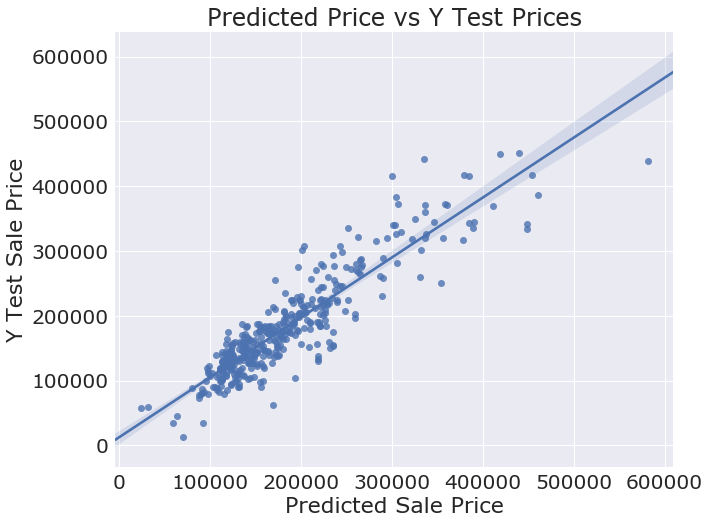

In [115]:
plt.figure(figsize=(10,8))
fig = sns.regplot(plot_predictions, y_test)
sns.set(font_scale=2, font='Verdana')
fig.set_title('Predicted Price vs Y Test Prices')
fig.set_xlabel('Predicted Sale Price')
fig.set_ylabel('Y Test Sale Price');

### Load in Test Data
Below I run everything I ran on the train data on the actual test data from which I make the actual predictions. 

In [87]:
test = pd.read_csv('./test.csv')

drop_cols = ['Alley', 'Pool QC', 'Misc Feature']
test.drop(axis=1, columns=drop_cols, inplace=True)

test['Year Built'] = 2018 - test['Year Built']
test['Year Remod/Add'] = 2018 - test['Year Remod/Add']

tst_cats = test.select_dtypes(exclude=[np.number])
tst_nums = test.select_dtypes(include=[np.number])
tst_cat_mask = list(tst_cats.columns)
tst_nums_mask = list(tst_nums.columns)

tst_cat_nans_mask = list(test[tst_cat_mask].isna().sum()[test.isna().sum() !=0].index)

imp = Imputer(axis=1)
tst_numerical_cols = imp.fit_transform(test[tst_nums_mask])
tst_numerical_cols = imp.transform(test[tst_nums_mask])

tst_numerical_cols = pd.DataFrame(tst_numerical_cols, columns=tst_nums_mask)

tst_cat_cols = test[tst_cat_mask]

for col in tst_cat_cols:
    tst_cat_cols[col].fillna(tst_cat_cols[col].value_counts().index[0], inplace=True)

test = pd.concat([tst_cat_cols,tst_numerical_cols], axis=1)

test.drop(columns=['Id','PID'],axis=1, inplace=True)

tst_dummies = pd.get_dummies(test[tst_cat_mask], drop_first=True)
full_test = pd.concat([test, tst_dummies], axis=1)

full_test.drop(columns=tst_cat_mask, axis=1, inplace=True)

test_cols = list(full_test.columns)

ss = StandardScaler()
ss.fit(full_test)
full_test = ss.transform(full_test)

full_test = pd.DataFrame(data=full_test, columns=test_cols)

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [88]:
full_test['Roof Matl_CompShg'] = 0
# This was not in the test data.

In [89]:
top_ten_lasso = ['Gr Liv Area','Overall Qual','Roof Matl_CompShg','Exter Qual_TA','Neighborhood_NridgHt','Kitchen Qual_TA','Exter Qual_Gd','Kitchen Qual_Gd','Neighborhood_StoneBr','Roof Matl_Tar&Grv']

full_test_ten = full_test[top_ten_lasso]

In [90]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)

full_test_poly = poly.fit_transform(full_test_ten)

In [91]:
prediction = lasso.predict(full_test_poly)

In [92]:
test2 = pd.read_csv('./test.csv')

In [93]:
submission = pd.DataFrame(data = prediction, index=test2['Id'], columns = ['SalePrice'])
submission.to_csv('./confoley_submission.csv')